# 1. Data Loading

In [149]:
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 2. Package imports

In [150]:
import json
import functools
import operator
from typing import List, Dict, Any
import os
import re
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
from tqdm import tqdm

import easyocr
from sklearn.model_selection import train_test_split

# 3. Examples
## 3.a. Open a single image

In [ ]:
id = '92094746'
image_path = f'data/train/images/{id}.png'
with open(f'data/train/annotations/{id}.json', 'r') as f:
    annotation = json.load(f)
image = Image.open(image_path)
#image_path = 'output.png'
#image = Image.open(image_path)

## 3.b. Display the bounding box

In [152]:
def draw_boxes(image:Image, annotation:dict) -> Image:
    # Create a drawing context
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Load a font
    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')    
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)
    
    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        text = dict_box['text']
        (x_min, y_min, x_max, y_max) = dict_box['box']
        if x_min < x_max and y_min< y_max:
            # Draw rectangle
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
            # Add text
            draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
        else:
            print(f"Bounding box is invalid: {dict_box['box']}")
    return image_with_boxes

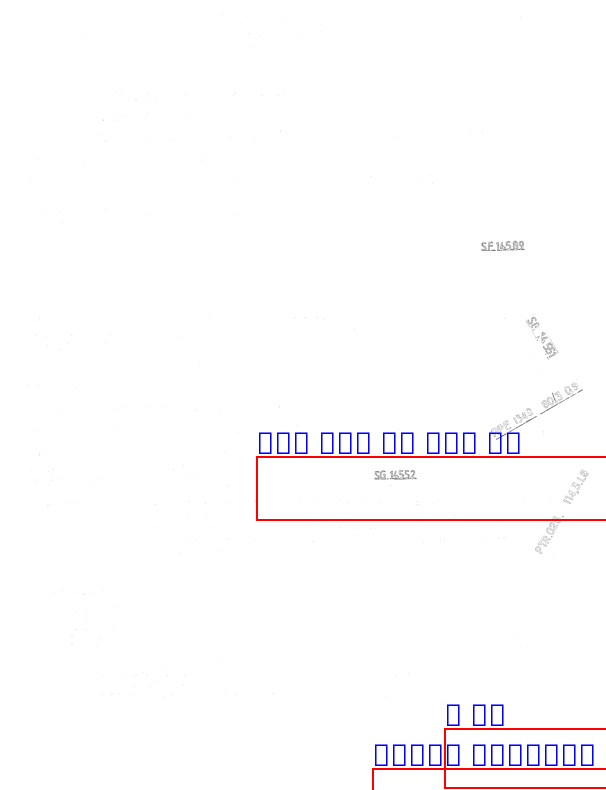

In [153]:
# Display the image with bounding boxes
draw_boxes(image, annotation)

## 3.c. Select only the 'RF' boxes

In [154]:
# Define a function to draw boxes only if the label correspond to the input
def draw_specific_boxes(image:Image, annotation:dict, specific_label:str) -> Image:
    # Create a drawing context
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Load a font
    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')    
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)
    
    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        label = dict_box['label']
        if label == specific_label:
            text = dict_box['text']
            (x_min, y_min, x_max, y_max) = dict_box['box']
            if x_min < x_max and y_min< y_max:
                # Draw rectangle
                draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
                # Add text
                draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
            else:
                print(f"Bounding box is invalid: {dict_box['box']}")
    return image_with_boxes

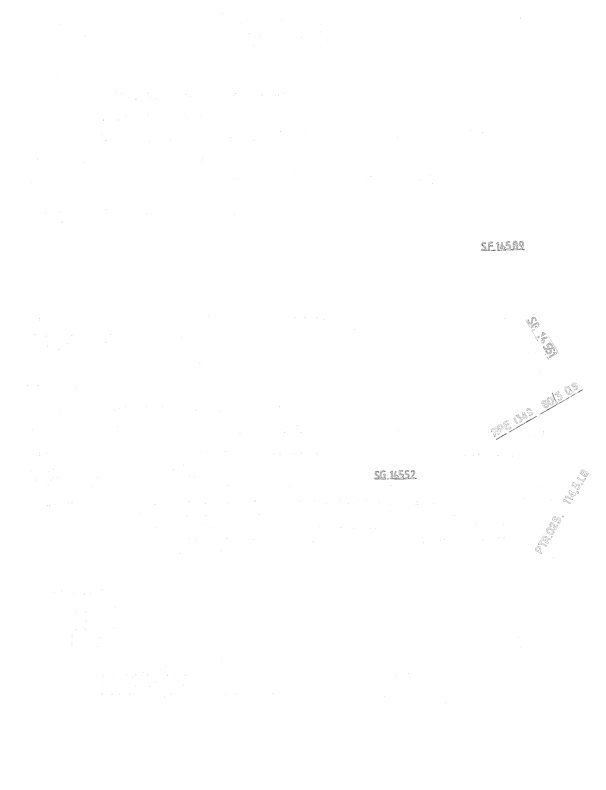

In [155]:
draw_specific_boxes(image, annotation, 'RF')

##### 

# 4. Example of OCR prediction : easyOCR

In [156]:
def analyze_image(image_path:str, language:str='en') -> list:
    """
    Analyze the image to detect text using EasyOCR.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    list: A list of tuples containing the bounding box, detected text, and confidence score for each detected text region.
    """
    # Create a Reader object for text detection
    reader = easyocr.Reader([language], gpu=False)  # You can activate/deactivate GPU
    
    # Read the text from the image
    resultats = reader.readtext(image_path)
    
    return resultats

In [157]:
def transform_result(results: List[Dict[str, Any]]) -> str:
    """
    Transforms OCR results into Challenge's JSON format.

    Args:
        results (List[Dict[str, Any]]): A list of OCR results where each result is a dictionary containing:
            - bbox (List[List[int]]): Bounding box coordinates.
            - text (str): Detected text.
            - prob (float): Confidence score.

    Returns:
        str: A JSON string representing the transformed OCR results.
    """
    form_data = []
    for idx, (bbox, text, prob) in enumerate(results):
        # Convert bounding box coordinates to integers
        bbox = [[int(coord) for coord in point] for point in bbox]
        box_extracted = [bbox[0], bbox[2]]
        flat_box = [coord for sublist in box_extracted for coord in sublist]
        
        # Create the structure for each element
        item = {
            "box": flat_box,
            "text": text,
            "label": "RF",  #### WARNING : Customize this field as needed !
            "words": [{"box": flat_box, "text": text}],  # Each word is encapsulated in a 'words' list
            "linking": [],  # This part can be used to link words if necessary
            "id": idx
        }
        
        form_data.append(item)

    # Convert to JSON
    json_data = {
        "form": form_data
    }

    # Convert JSON data to a formatted string
    #json_output = json.dumps(json_data, indent=4, ensure_ascii=False)
    return json_data

In [158]:
results = transform_result(analyze_image(image_path))
print(results)

Using CPU. Note: This module is much faster with a GPU.


{'form': [{'box': [479, 239, 527, 255], 'text': 'SELSAA', 'label': 'RF', 'words': [{'box': [479, 239, 527, 255], 'text': 'SELSAA'}], 'linking': [], 'id': 0}, {'box': [511, 407, 537, 427], 'text': '6', 'label': 'RF', 'words': [{'box': [511, 407, 537, 427], 'text': '6'}], 'linking': [], 'id': 1}, {'box': [373, 469, 419, 483], 'text': '56,14552', 'label': 'RF', 'words': [{'box': [373, 469, 419, 483], 'text': '56,14552'}], 'linking': [], 'id': 2}, {'box': [533, 400, 571, 400], 'text': 'LL', 'label': 'RF', 'words': [{'box': [533, 400, 571, 400], 'text': 'LL'}], 'linking': [], 'id': 3}, {'box': [574, 472, 573, 512], 'text': '4', 'label': 'RF', 'words': [{'box': [574, 472, 573, 512], 'text': '4'}], 'linking': [], 'id': 4}]}


Bounding box is invalid: [533, 400, 571, 400]
Bounding box is invalid: [574, 472, 573, 512]


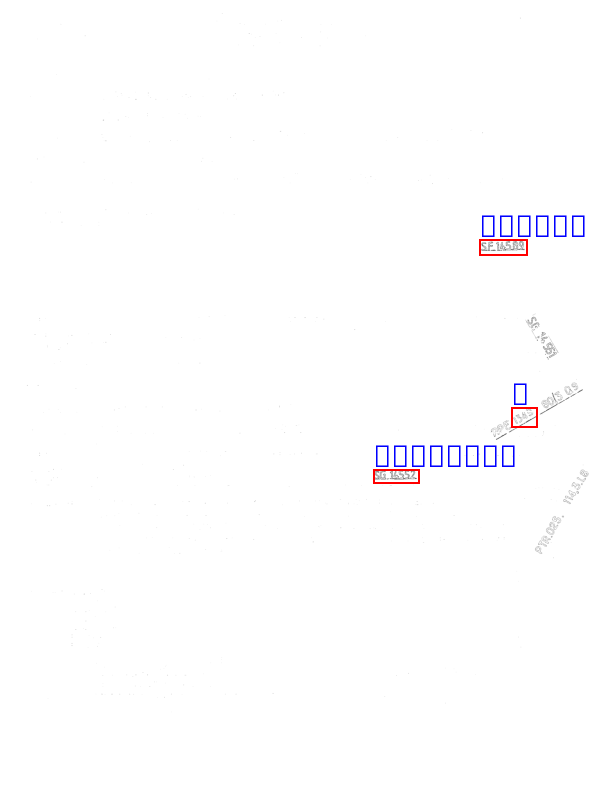

In [159]:
draw_specific_boxes(image, results, 'RF')

# 5. Compute score

You need to put the true annotations in a folder and your predictions in another folder to compute results

In [160]:
# Create a folder to store JSON predictions
output_folder = 'output_easyocr'
# !mkdir -p {output_folder}
os.makedirs(output_folder, exist_ok=True)

# Create a folder to store ground truth JSON
ground_truth_folder = 'ground_truth_annotations'
# !mkdir -p {ground_truth_folder}
os.makedirs(ground_truth_folder, exist_ok=True)

In [161]:
# Save predictions
json_output = json.dumps(results, indent=4, ensure_ascii=False)
with open(f'{output_folder}/{id}.json', 'w', encoding='utf-8') as f:
    f.write(json_output)

# Save true annotations
input_path = f'data/train/annotations/{id}.json'
output_path = f'{ground_truth_folder}/{id}.json'

with open(input_path, 'r', encoding='utf-8') as file:
    annotation = json.load(file)

# Write the annotation JSON to the ground truth folder
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(annotation, f, ensure_ascii=False, indent=4)  # Properly write JSON


In [162]:
# Utils functions to compute result

def clean_txt(s: str) -> str:
    return re.sub(r'[^A-Z0-9]+', '', s.upper())


get_rects = functools.partial(map, operator.itemgetter('box'))
get_texts = functools.partial(map, operator.itemgetter('text'))


def compute_overlap(gt: np.array, preds: np.array) -> np.array:
    _gt = np.tile(np.expand_dims(gt, axis=1), (1, preds.shape[0], 1))
    _p = np.tile(np.expand_dims(preds, axis=0), (gt.shape[0], 1, 1))

    dx = np.minimum(_gt[:, :, 2], _p[:, :, 2]) - np.maximum(_gt[:, :, 0], _p[:, :, 0])
    dy = np.minimum(_gt[:, :, 3], _p[:, :, 3]) - np.maximum(_gt[:, :, 1], _p[:, :, 1])

    area = dx * dy
    # valid area if dx > 0 and dy > 0
    overlap = np.where(np.logical_and(dx > 0, dy > 0), area, 0)

    return overlap


def compute_area(rects: np.array) -> np.array:
    return (rects[:, 2] - rects[:, 0]) * (rects[:, 3] - rects[:, 1])


def compute_iou(gt: np.array, preds: np.array) -> np.array:
    gt_area = compute_area(gt)
    p_area = compute_area(preds)

    _gt_area = np.tile(gt_area[:, np.newaxis], (1, preds.shape[0]))
    _p_area = np.tile(p_area[np.newaxis, ], (gt.shape[0], 1))

    overlap = compute_overlap(gt, preds)

    _iou = overlap / (_gt_area + _p_area - overlap)

    return np.amax(_iou, axis=1), np.argmax(_iou, axis=1)


def compute_correct_rf(gt_texts: list, preds_texts: list, iou_results, iou_threshold=0.25) -> int:
    iou, best_iou_id = iou_results
    n_corrects = 0
    for i_txt, text in enumerate(gt_texts):
        if clean_txt(text) in clean_txt(preds_texts[best_iou_id[i_txt]]) and iou[i_txt] > iou_threshold:
            n_corrects += 1

    return n_corrects


def compute_results(gt: list, preds: list):
    gt = list(filter(lambda x: x['label'] == 'RF', gt))
    gt_rects = np.array(list(get_rects(gt)))
    gt_texts = list(get_texts(gt))

    p_rects = np.array(list(get_rects(preds)))
    p_texts = list(get_texts(preds))

    n_gt_rects = len(gt_rects)

    if n_gt_rects == 0:
        return 1.0, 1.0

    iou, best_iou_id = compute_iou(gt_rects, p_rects)
    # print("IOU: ", iou)
    # print("Best IOU ID: ", best_iou_id)
    n_corrects = compute_correct_rf(gt_texts, p_texts, (iou, best_iou_id))

    return np.sum(iou)/n_gt_rects, n_corrects/n_gt_rects

In [163]:
def compute_result(ground_truth, predictions):
    means_ious = []
    means_rf = []

    for file in os.listdir(ground_truth):
        with open(os.path.join(ground_truth, file), 'rb') as f:
            gt_json = json.load(f)

        pred_file = os.path.join(predictions, file)
        if os.path.isfile(pred_file):
            with open(pred_file, 'rb') as f:
                preds_json = json.load(f)

        else:
            means_ious.append(0)
            means_rf.append(0)
            continue

        file_iou, file_rf = compute_results(
            gt_json['form'],
            preds_json['form']
        )
        means_ious.append(file_iou)
        means_rf.append(file_rf)
    print(f"IOU: {np.mean(means_ious) * 100:.2f}")
    print(f"RF Correct: {np.mean(means_rf) * 100:.2f}")
    return means_ious, means_rf


In [164]:
gt_folder = os.path.join(os.getcwd(), ground_truth_folder)
pred_folder = os.path.join(os.getcwd(), output_folder)

iou, rf = compute_result(gt_folder, pred_folder)

IOU: 0.00
RF Correct: 0.00


# 6. From json to csv format

You need to create csv and make sure commas are replaced by semi-commas.

In [165]:
# import os
# import json
# import pandas as pd

# # Initialize an empty list to store the form data
# form_data_list = []
# ids = []
# # Iterate through each file in the directory
# for filename in os.listdir(output_folder):
#     if filename.endswith('.json'):
#         file_path = os.path.join(output_folder, filename)
#         with open(file_path, 'r') as file:
#             data = json.load(file)
#             form_data_list.append(data['form'])
#             ids.append(filename.split('.')[0])
# # Create a DataFrame from the form data list
# target_form = pd.DataFrame()
# target_form['id'] = ids
# target_form['target'] = form_data_list
# target_form['target'] = target_form['target'].astype(str)
# target_form = target_form.replace(',', ';', regex=True)  # Here we replace , by ;
# target_form['Usage'] = 'Public'


In [166]:
#target_form.to_csv('sample_submission.csv', index=False, sep=',')

# 7. Example of a Random Submission

In [167]:
# def submit():
#     start_path = "/kaggle/input/intelligent-text-extraction/test/images"
    
#     dataframe_liste = []
#     for root, dirs, files in os.walk(start_path):
#         for file in files:
#             image_path = os.path.join(root, file)
#             image_id = os.path.basename(image_path).split(".")[0]
#             image = Image.open(image_path)
    
#             ### change code here to incorporate your predictions
#             box = list(np.random.randint(0, 4000, 4))
#             text = "ETY017359D3"
#             ###
            
#             target = [{'box': box, 'text': text}]
#             target_tocsv = str(target).replace(',', ';')
#             line = {"id": image_id, "target": target_tocsv, "Usage": "Public"}
#             dataframe_liste.append(line)
    
#     df = pd.DataFrame(dataframe_liste)
#     df.to_csv("submission.csv", index=False)

# submit()